In [1]:
#imports
import gzip
import pandas as pd
import os
from collections import defaultdict
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import ast
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
#define path
path = os.getcwd()
print(path)

c:\Users\fried\Desktop\Project_emerson


# Functions 

### 1. Match patients with TCRs
##### Read all the patient files and make a dictionary where key = combination, value = list of reperoire_ids

In [3]:
def read_patient_files(patients_path, number_of_patients=666, training=True):
    files_path = path + patients_path #'\\data\\HLA_emerson_2017'

    all_files = os.listdir(files_path)

    tsv_gz_files = [f for f in all_files if f.endswith('.tsv.gz')]

    if training == True:
        tsv_gz_files = tsv_gz_files[:number_of_patients] #tsv_gz_files[:400]

    elif training == False:
        tsv_gz_files = tsv_gz_files[number_of_patients:]

    patient_names = [f.split('.')[0] for f in tsv_gz_files]

    return tsv_gz_files, patient_names

In [4]:
def matching_patients_tcrs(patients_path, number_of_patients=400):
    tsv_gz_files, patient_names = read_patient_files(patients_path, number_of_patients)

    files_path = path + patients_path #'\\data\\HLA_emerson_2017'

    clonotype_occurences = defaultdict(set)

    for f in tsv_gz_files:
        file_path = os.path.join(files_path, f)
        with gzip.open(file_path, 'rt') as fi:
            # Inlezen als pandas DataFrame
            df = pd.read_csv(fi, sep='\t')
            
            for row in df.itertuples(index=False):
                combination = (row.v_call, row.junction_aa, row.j_call)
                rep_id = row.repertoire_id
                clonotype_occurences[combination].add(rep_id)


    tcr_df = pd.DataFrame(list(clonotype_occurences.items()), columns=['combination', 'repertoire_ids'])
    tcr_df = tcr_df[tcr_df['repertoire_ids'].apply(len) >= 5]
    tcr_df.reset_index(drop=True, inplace=True)
    return tcr_df



In [5]:
def write_to_file(data, filename):
    data.to_csv(filename, sep='\t', index=False)

In [6]:
def read_file(filename):
    return pd.read_csv(filename, sep='\t')

In [8]:
## execute the function
tcr_df = matching_patients_tcrs('\\data\\HLA_emerson_2017')


KeyboardInterrupt: 

In [9]:
#write_to_file(tcr_df, 'results\\tcr_df_output.tsv')
tcr_df = read_file('results\\tcr_df_output.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)

### 2. Match HLA-labelling of patients
##### Match the HLA-labelling with the patient files (A_02_01_features.txt contains the indices to the patient files)


In [7]:
def match_hla(patients_path, hla_path):
    tsv_gz_files, all_patient_names = read_patient_files(patients_path)

    record =  {}  # Temporary dictionary to hold one record
    file_path = path + hla_path #'\\data\\A_02_01_features.txt'

    # Read and parse the file
    with open(file_path, "r") as file:
        for line in file:
            line = line.split(" ")
            if line[1] == 'HLA-A*02:01':
                key = line[2]
                for i in range(5, len(line)):
                    value = line[i]
                    if value == '\n':
                        continue
                    ## value is the index to the patient file
                    patient = all_patient_names[int(value)]
                    if key in ['num_positives:']:
                        record[patient] = True
                    elif key in ['num_negatives:']:
                        record[patient] = False   


    for patient in all_patient_names:
        if patient not in record.keys():
            record[patient] = None

    patient_df = pd.DataFrame(list(record.items()), columns=['repertoire_id', 'has_HLA_A02_01'])
    patient_df.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
    return patient_df
   
    

In [8]:
## select number of patients of the hla labelling for training or testing and remove rows with missing values
def select_patients_hla_labelling(patient_df, number_of_patients=666, hla_column='has_HLA_A02_01', training=True):
    if training == True:
        patient_df = patient_df.iloc[:number_of_patients]
    elif training == False:
        patient_df = patient_df.iloc[number_of_patients:]
    patient_df = patient_df[patient_df['has_HLA_A02_01'].notna()]
    patient_df.reset_index(drop=True, inplace=True)    
    return patient_df

In [9]:
patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df)

print(patient_df)   

         repertoire_id has_HLA_A02_01
0    P00001_clonotypes          False
1    P00002_clonotypes           True
2    P00003_clonotypes           True
3    P00004_clonotypes           True
4    P00005_clonotypes          False
..                 ...            ...
624  P00663_clonotypes           True
625  P00665_clonotypes           True
626  P00666_clonotypes          False
627  P00667_clonotypes          False
628  P00668_clonotypes          False

[629 rows x 2 columns]


### 3. Fisher-exact method
#####  Make a dataframe where every row contains the TCR (combination), the p-value and odds ratio of fisher_exact method (use psuedocount of 0.1)

In [10]:
def execute_fisher_exact(tcr_df, patient_df):
    fisher_exact_results = []
    for index, row in tcr_df.iterrows():
        # Haal de eerste rij van tcr_df en zijn combinatie en repertoire_ids
        repertoire_ids = row['repertoire_ids']  # Aangenomen dat repertoire_ids een lijst is
        combination = row['combination']

        # Filter patient_df op basis van de repertoire_ids
        filtered_patients = patient_df[patient_df['repertoire_id'].isin(repertoire_ids)]

        # Tel het aantal patiënten in elke categorie
        have_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == True]) + 0.1  # Aantal met HLA en TCR
        have_no_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == False]) + 0.1  # Aantal zonder HLA maar met TCR


        # Aantal patiënten zonder TCR
        have_hla_no_tcr = len(patient_df[(patient_df['has_HLA_A02_01'] == True) & 
                                                (~patient_df['repertoire_id'].isin(repertoire_ids))]) + 0.1
        have_no_hla_no_tcr = len(patient_df[(patient_df['has_HLA_A02_01'] == False) & 
                                                    (~patient_df['repertoire_id'].isin(repertoire_ids))]) + 0.1
        

        # Maak de 2x2-contingentietabel
        contingency_table = [
            [
                have_hla_and_tcr,  # a: patiënten met zowel HLA als TCR
                have_no_hla_and_tcr  # b: patiënten zonder HLA maar met TCR
            ],
            [
                have_hla_no_tcr,  # c: patiënten met HLA maar zonder TCR
                have_no_hla_no_tcr  # d: patiënten zonder HLA en zonder TCR
            ]
        ]


        # Voer de Fisher's Exact Test uit
        odds_ratio, p_value = fisher_exact(contingency_table)

        # Voeg de resultaten toe aan de lijst
        fisher_exact_results.append({
            'HLA': 'HLA-A*02:01',
            'TCR': combination,
            'odds_ratio': odds_ratio,
            'p_value': p_value,
            'have_hla_and_tcr' : have_hla_and_tcr,
            'have_no_hla_and_tcr': have_no_hla_and_tcr,
            'have_hla_no_tcr': have_hla_no_tcr,
            'have_no_hla_no_tcr': have_no_hla_no_tcr
        })

    # Zet de resultaten om in een DataFrame
    fisher_exact_results_df = pd.DataFrame(fisher_exact_results)

    # Neem de -log10 van de p-value en de log2 van de odds_ratio en voeg ze toe aan de DataFrame
    fisher_exact_results_df['log2_odds_ratio'] = np.log2(fisher_exact_results_df['odds_ratio'])
    fisher_exact_results_df['neg_log10_p_value'] = -np.log10(fisher_exact_results_df['p_value'])

    # Voeg een kolom toe om te controleren of de p-value kleiner is dan 0.05
    fisher_exact_results_df['significant'] = fisher_exact_results_df['p_value'] < 0.05

    return fisher_exact_results_df



In [11]:
def generate_volcano_plot(fisher_exact_results_df, filename):
    # Maak een Volcano Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=fisher_exact_results_df, 
                    x='log2_odds_ratio', 
                    y='neg_log10_p_value',
                    hue='significant')
    plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
    plt.xlabel('log2(Odds Ratio)')
    plt.ylabel('-log10(p-value)')
    plt.title('Volcano Plot')
    plt.savefig(filename)
    plt.show()

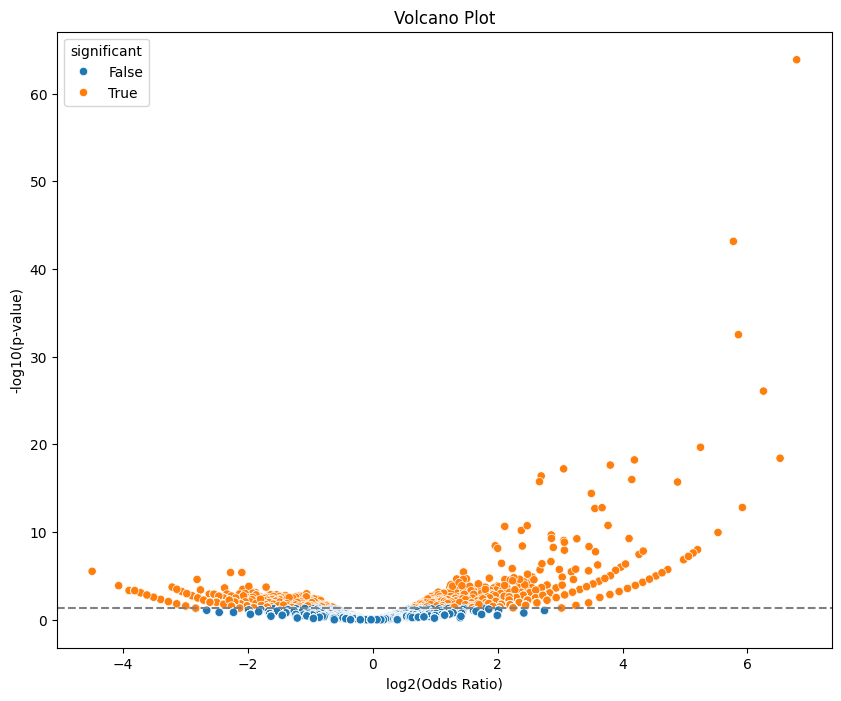

In [ ]:
patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df, 400)
fisher_exact_results_df = execute_fisher_exact(tcr_df, patient_df)
write_to_file(fisher_exact_results_df, 'results\\fisher_exact_results.tsv')

generate_volcano_plot(fisher_exact_results_df, 'results\\plots\\volcano_plot.png')

### 4. Train classifier model
#####  match/count the HLA-02.01 related TCR's for every patient
##### make a table with 3 columns: patient, #total TCR's and #HLA-02.01 related TCR's (from the fisher_exact_results_df where p-value < 0.05 and odds_ratio > 1)

In [12]:
def apply_benjamini_hochberg(fisher_exact_results_df):
    # Voer de Benjamini-Hochberg-correctie uit
    fisher_exact_results_df = fisher_exact_results_df.sort_values(by='p_value').reset_index(drop=True)
    fisher_exact_results_df['corrected_p_value'] = fisher_exact_results_df['p_value'] * len(fisher_exact_results_df) / (fisher_exact_results_df.index + 1)

    return fisher_exact_results_df

In [13]:
def match_and_select_related_tcrs(fisher_exact_results_df, hla_labelling, patients_path, top_n=10, number_patients=666, sort_column='p_value', benjamini_hochberg=False):
    tsv_gz_files, patient_names = read_patient_files(patients_path, number_patients)

    files_path = path + patients_path #'\\data\\HLA_emerson_2017'

    result_data = []
    related_tcrs = fisher_exact_results_df[(fisher_exact_results_df['p_value'] < 0.05) & (fisher_exact_results_df['odds_ratio'] > 1)].reset_index(drop=True)
    print("Related TCRs fisher exact: ",len(related_tcrs)) 
    top_related_tcrs = related_tcrs.sort_values(by=[sort_column]).head(top_n)

    if benjamini_hochberg:
        fisher_exact_results_df = apply_benjamini_hochberg(fisher_exact_results_df)
        related_tcrs = fisher_exact_results_df[(fisher_exact_results_df['corrected_p_value'] < 0.05) & (fisher_exact_results_df['odds_ratio'] > 1)].reset_index(drop=True)
        if sort_column == 'p_value':
            top_related_tcrs = related_tcrs.sort_values(by=['corrected_p_value']).head(top_n)
        else:
            top_related_tcrs = related_tcrs.sort_values(by=[sort_column]).head(top_n)

    print("Related TCRs Benjamini: ",len(top_related_tcrs)) 

    
    for f in tsv_gz_files:
        file_path = os.path.join(files_path, f)
        with gzip.open(file_path, 'rt') as fi:
            # Inlezen als pandas DataFrame
            df = pd.read_csv(fi, sep='\t')
            
            # Controleer of DataFrame niet leeg is
            if df.empty:
                continue
            
            # Voeg de TCR-combinaties toe als tuple
            if {'v_call', 'junction_aa', 'j_call'}.issubset(df.columns):
                df['TCR'] = [tuple(tcr) for tcr in zip(df['v_call'], df['junction_aa'], df['j_call'])]            
            else:
                continue  # Sla over als de vereiste kolommen ontbreken
            
            # Haal totalen op
            total_tcrs = len(df)
            rep_id = df['repertoire_id'].iloc[0]  # Gebruik .iloc om een fout te voorkomen

            # check if value of HLA-A*02:01 is NaN
            has_hla = None
            hla_row = hla_labelling[hla_labelling['repertoire_id'] == rep_id]
            if not hla_row.empty:
                has_hla = hla_row['has_HLA_A02_01'].iloc[0]
            #if hla is NaN value, change to None
            if pd.isna(has_hla):  # Controleer of de waarde NaN is
                has_hla = None
            
            # Zoek naar matches met de significante TCRs
            matching_tcrs = df[df['TCR'].isin(top_related_tcrs['TCR'])].shape[0]
            
            # Voeg de resultaten toe aan de lijst
            result_data.append({
                'repertoire_id': rep_id,
                'total_tcrs': total_tcrs,
                'related_tcrs': matching_tcrs,
                'has_HLA_A02_01': has_hla
            })

    # Als je de data als een DataFrame wilt hebben
    result_df = pd.DataFrame(result_data)

    if len(top_related_tcrs) < top_n:
        return result_df, len(top_related_tcrs)

    return result_df 

    

In [14]:
def calculate_metrics(result_df):
    # Compute the confusion matrix
    cm = confusion_matrix(result_df['has_HLA_A02_01_label'], result_df['prediction'])
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    sensitivity = TP / (TP + FN)  # True Positive Rate
    specificity = TN / (TN + FP)  # True Negative Rate
    accuracy = (TP + TN) / (TP + TN + FP + FN)  # Overall accuracy

    # Print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    print(classification_report(result_df['has_HLA_A02_01_label'], result_df['prediction'], target_names=['Class 0', 'Class 1']))
    return sensitivity, specificity, accuracy

In [15]:
#make a ROC curve for the trained model
def plot_roc_curve(result_df, top_n, training=True, benjamini_hochberg=False, threshold=None):
    fpr, tpr, thresholds = roc_curve(result_df['has_HLA_A02_01_label'], result_df['probability'])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Chance')

    # Add labels, title, and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    title = "ROC Logistic Regression top " + str(top_n) + " related tcrs"
    filename = 'results\\plots\\ROC_Logistic_Regression_top' + str(top_n) + '_related_tcrs.png'

    if training == True:
        filename = 'results\\plots\\ROC_Logistic_Regression_top' + str(top_n) + '_related_tcrs_training.png'
        title = "ROC Logistic Regression top " + str(top_n) + " related tcrs (Training set)"
        if benjamini_hochberg and threshold == None:
            filename = 'results\\plots\\ROC_Logistic_Regression_top' + str(top_n) + '_related_tcrs_training_bh.png'
            title = "ROC Logistic Regression top " + str(top_n) + " related tcrs (Training set, Benjamini-Hochberg)"
        elif benjamini_hochberg and threshold != None:
            filename = 'results\\plots\\ROC_Logistic_Regression_top' + str(top_n) + '_related_tcrs_training_bh_threshold_' +  str(threshold) + '.png'
            title = "ROC Logistic Regression top " + str(top_n) + " related tcrs (Training set, Benjamini-Hochberg, Threshold = " + str(threshold) + ")"
        
    elif training == False:
        filename = 'results\\plots\\ROC_Logistic_Regression_top' + str(top_n) + '_related_tcrs_validation.png'
        title = "ROC Logistic Regression top " + str(top_n) + " related tcrs (Validation set)"
        if benjamini_hochberg and threshold == None:
            filename = 'results\\plots\\ROC_Logistic_Regression_top' + str(top_n) + '_related_tcrs_validation_bh.png'
            title = "ROC Logistic Regression top " + str(top_n) + " related tcrs (Validation set, Benjamini-Hochberg)"
        elif benjamini_hochberg and threshold != None:
            filename = 'results\\plots\\ROC_Logistic_Regression_top' + str(top_n) + '_related_tcrs_validation_bh_threshold_' +  str(threshold) + '.png'
            title = "ROC Logistic Regression top " + str(top_n) + " related tcrs (Validation set, Benjamini-Hochberg, Threshold = " + str(threshold) + ")"
    
    print(title)
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.5)
    plt.savefig(filename)  
    plt.show()

    return roc_auc

In [16]:
def make_classifier(result_df, top_n=10, benjamini_hochberg=False, filename=None):
    # make classifier logistic regression: 
    # - features are total_tcrs and related_tcrs
    # - target is has_HLA_A02_01 
    # - save the model

    model = LogisticRegression()
    X = result_df[['total_tcrs', 'related_tcrs']]
    y = result_df['has_HLA_A02_01_label']
    model.fit(X, y)
    
    result_df['probability'] = model.predict_proba(X)[:, 1]
    result_df['prediction'] = model.predict(X)


    #save the model
    if benjamini_hochberg and filename == None:
        dump(model, 'results\\models\\logistic_regression_top' + str(top_n) + '_related_tcrs_bh.joblib')
    elif benjamini_hochberg == False and filename == None:
        dump(model, 'results\\models\\logistic_regression_top' + str(top_n) + '_related_tcrs.joblib')

    else:
        dump(model, filename)

    return result_df, model



In [17]:
def plot_total_vs_significant_tcrs(result_df, top_n=10, training=True, threshold=None):
    # Zorg ervoor dat de kolom consistente typen heeft
    # Zet None om naar een string 'None'
    result_df['has_HLA_A02_01'] = result_df['has_HLA_A02_01'].map(
        {True: True, False: False, None: 'None'}
    )

    plt.figure(figsize=(8, 6))  # Stel de grootte van de plot in
    palette = {True: 'green', False: 'red', 'None': 'blue'}

    # Maak de scatterplot met juiste kleurtoewijzing
    sns.scatterplot(
        x=result_df['total_tcrs'], 
        y=result_df['related_tcrs'], 
        hue=result_df['has_HLA_A02_01'],  # Gebruik de aangepaste kolom voor 'hue'
        palette=palette  # Geef kleuren op via het palette
    )

    # Voeg labels en titel toe
    plt.xlabel('# Total TCRs')
    plt.ylabel('# Significant TCRs')
    plt.legend(title='Has HLA-A*02:01', loc='upper right')
    
    if training == True:
        if threshold != None:
            plt.title('Total vs Significant TCRs per Patient TCRs(Training set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ')')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Training set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ').png')
        else:
            plt.title('Total vs Significant TCRs per Patient TCRs(Training set, Top ' + str(top_n) + ' TCRs)')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Training set, Top ' + str(top_n) + ' TCRs)')
    else:
        if threshold != None:
            plt.title('Total vs Significant TCRs per Patient TCRs(Validation set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ')')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Validation set, Top ' + str(top_n) + ' TCRs, Threshold ' + str(threshold) + ').png')
        else:
            plt.title('Total vs Significant TCRs per Patient TCRs(Validation set, Top ' + str(top_n) + ' TCRs)')
            plt.savefig('results\\plots\\Total vs Significant TCRs per Patient_TCRs(Validation set, Top ' + str(top_n) + ' TCRs)')
            
    # Toon de plot
    plt.show()

### 5. Select different top related TRCs, train the model and calculate metrics
##### Make a table with the different metrics (AUC, sensitivity, specificity, accuracy) and different top related TCRs
##### Apply Benjamini-Hochberg correction
##### Select top n related TCRs based on p-value

C:\Users\fried\AppData\Local\Temp\ipykernel_15252\3862811020.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
C:\Users\fried\AppData\Local\Temp\ipykernel_15252\3862811020.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression top 100 related tcrs (Training set)


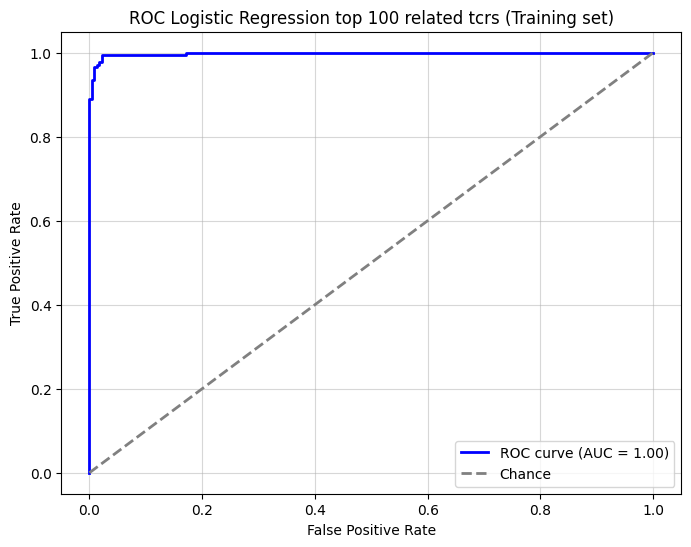

Sensitivity: 0.98
Specificity: 0.98
Accuracy: 0.98
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       228
     Class 1       0.98      0.98      0.98       172

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

ROC Logistic Regression top 100 related tcrs (Validation set)


C:\Users\fried\AppData\Local\Temp\ipykernel_15252\2950170331.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
C:\Users\fried\AppData\Local\Temp\ipykernel_15252\2950170331.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


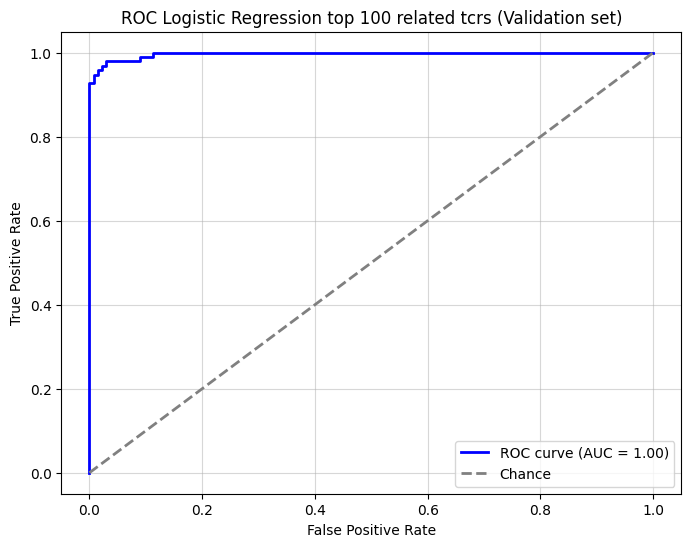

Sensitivity: 0.96
Specificity: 0.98
Accuracy: 0.97
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       133
     Class 1       0.98      0.96      0.97        96

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



In [108]:
top_n = [5, 10, 20, 30, 50, 90, 100, 500, 1000, 5000, 10000, 20000]


metrics_training_data = []
metrics_validation_data = []

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df)

fisher_exact_results_df = read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)

BN = [False]

for bn in BN:
# Filter the top_n list dynamically
    if bn:
        top_n = [n for n in top_n if n <= 90]  # Use only smaller values for BH correction

    for n in top_n:
        #training set
        result_df = match_and_select_related_tcrs(fisher_exact_results_df, patient_df, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
        result_df_copy = result_df.copy()

        # Make a label for the target (has_HLA_A02_01), model can't handle boolean values
        # 0 = False, 1 = True
        result_df['has_HLA_A02_01'] = result_df['has_HLA_A02_01'].replace('None', np.nan)
        #drop none values
        result_df = result_df.dropna()
        result_df['has_HLA_A02_01_label'] = result_df['has_HLA_A02_01'].astype('category').cat.codes
        
        #select first 400 patients for training
        result_df.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
        result_df_training = result_df.iloc[:400]

        result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn)

        # Make roc curve
        roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

        metrics_training_data.append({
            'top_n': n, 
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        }) 
        result_df_training_plot = result_df_copy.iloc[:400]
        plot_total_vs_significant_tcrs(result_df_training_plot, n)

        #validation set
        result_df_validation = result_df.iloc[400:]
        X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
        y_val = result_df_validation['has_HLA_A02_01_label']
        result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
        result_df_validation['prediction'] = model.predict(X_val)
        roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn)
        sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

        metrics_validation_data.append({
            'top_n': n, 
            'benjamini_hochberg': bn,
            'roc_auc': roc_auc, 
            'sensitivity': sensitivity, 
            'specificity': specificity, 
            'accuracy': accuracy
        })
        result_df_validation_plot = result_df_copy.iloc[400:]
        plot_total_vs_significant_tcrs(result_df_validation_plot, n, False)


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\metrics_classifiers_training.tsv')
write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation.tsv')

metrics_training_df
metrics_validation_df

In [67]:
#metrics_training_df

,top_n,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,False,0.497807,0.000000,1.000000,0.5700
1,10,False,0.985669,0.959302,0.978070,0.9700
2,20,False,0.995614,0.982558,0.995614,0.9900
3,30,False,0.999210,0.982558,0.991228,0.9875
4,50,False,0.995461,0.970930,0.978070,0.9750
5,90,False,0.997348,0.976744,0.982456,0.9800
6,100,False,0.997986,0.976744,0.982456,0.9800
7,500,False,1.000000,1.000000,0.995614,0.9975
8,1000,False,1.000000,1.000000,1.000000,1.0000
9,5000,False,0.999541,0.994186,0.995614,0.9950


### 6. Semi-supervised learning
##### semi-supervised learning of self-training, een model wordt gebruikt om labels toe te kennen aan nieuwe data (pseudo-labeling), en deze worden vervolgens toegevoegd aan de trainingsdata voor een nieuwe iteratie van modeltraining.

In [63]:
tcr_df = matching_patients_tcrs('\\data\\HLA_Mitchell_Michels_2022')

In [ ]:
write_to_file(tcr_df, 'results\\tcr_df_output_Mitchell.tsv')

In [96]:

tcr_df = read_file('results\\tcr_df_output_Mitchell.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)
tcr_df.head()

,combination,repertoire_ids
0,"('TRBV7-9', 'CASSLARSTGELFF', 'TRBJ2-2')","{DenverT1D-258_TCRB, Daisy-20_TCRB, DenverT1D-..."
1,"('TRBV7-9', 'CASSLEGTGGAAYGYTF', 'TRBJ1-2')","{DenverT1D-354_TCRB, 310216_TCRB, Daisy-16_TCR..."
2,"('TRBV6-4', 'CASSGENTGELFF', 'TRBJ2-2')","{310126_TCRB, 310216_TCRB, 310221_TCRB, Denver..."
3,"('TRBV28', 'CASSSDRVYGYTF', 'TRBJ1-2')","{DenverT1D-253_TCRB, DenverT1D-243_TCRB, 31028..."
4,"('TRBV6-4', 'CASSLTGTNSPLHF', 'TRBJ1-6')","{DenverT1D-184_TCRB, DenverT1D-095_TCRB, 31021..."


In [101]:
def read_patients_hla_labelling(hla_path):
    # Read the patients TCR files and make table with related TCRs
    patient_allel_path = path +  hla_path #"\\data\\HLA_Mitchell_Michels_2022.tsv"

    # Lees het TSV-bestand in als DataFrame
    patient_df_mitchell = pd.read_csv(patient_allel_path, sep='\t')


    # Definieer de kolommen die gecontroleerd moeten worden op lege lijsten
    hla_columns = ['HLA-A']#, 'HLA-B', 'HLA-C', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DPB1']

    # Filter de DataFrame om alleen rijen te behouden waar niet alle HLA-kolommen '[]' bevatten
    patient_df_filtered = patient_df_mitchell[~patient_df_mitchell[hla_columns].apply(lambda row: all(val == '[]' for val in row), axis=1)]

    #Remove all rows where column 'HLA-A' is NaN
    patient_df_filtered = patient_df_filtered[patient_df_filtered['HLA-A'].notna()]

    # Reset de indexen
    patient_df_filtered.reset_index(drop=True, inplace=True)

    patient_df_filtered = patient_df_filtered[['patient_id', 'HLA-A']]
    patient_df_filtered.rename(columns={'patient_id': 'repertoire_id'}, inplace=True)

    patient_df_filtered['has_HLA_A02_01'] = patient_df_filtered['HLA-A'].apply(lambda x: 'A*02:01' in x if isinstance(x, str) else False)
    patient_df_filtered = patient_df_filtered[['repertoire_id', 'has_HLA_A02_01']] 
    return patient_df_filtered

In [119]:

patient_df_mitchel = read_patients_hla_labelling('\\data\\HLA_Mitchell_Michels_2022.tsv')
patient_df_mitchel

    


,repertoire_id,has_HLA_A02_01
0,310148_TCRB,False
1,310230_TCRB,False
2,310122_TCRB,True
3,310204_TCRB,True
4,310221_TCRB,False
...,...,...
211,310106_TCRB,False
212,310113_TCRB,True
213,310266_TCRB,True
214,310175_TCRB,False


In [103]:
fisher_exact_results_df = execute_fisher_exact(tcr_df, patient_df_mitchel)
write_to_file(fisher_exact_results_df, 'results\\fisher_exact_results_Mitchell.tsv')


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [107]:
fisher_exact_results_df_mitchel = read_file('results\\fisher_exact_results_Mitchell.tsv')
fisher_exact_results_df_mitchel['TCR'] = fisher_exact_results_df_mitchel['TCR'].apply(ast.literal_eval)

In [120]:
result_df_mitchel = match_and_select_related_tcrs(fisher_exact_results_df_mitchel, patient_df_mitchel, '\\data\\HLA_Mitchell_Michels_2022', 100, benjamini_hochberg=False)
len(result_df_mitchel)

359

In [121]:
result_df_mitchel

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,310101_TCRB,12759,2,True
1,310102_TCRB,67451,0,False
2,310103_TCRB,59566,8,True
3,310104_TCRB,108101,15,True
4,310105_TCRB,146091,11,True
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,None
355,DenverT1D-383_TCRB,30351,0,None
356,DenverT1D-384_TCRB,219423,12,None
357,DenverT1D-386_TCRB,188585,17,None


In [122]:
## Read a trained model (Benjamini-Hochberg correction and top 50 related TCRs)
model = load('results\\models\\logistic_regression_top100_related_tcrs.joblib')
X_val = result_df_mitchel[['total_tcrs', 'related_tcrs']]


result_df_mitchel['probability'] = model.predict_proba(X_val)[:, 1]
result_df_mitchel['prediction'] = model.predict(X_val)

In [123]:
result_df_mitchel.head(10)

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01,probability,prediction
0,310101_TCRB,12759,2,True,0.594227,1
1,310102_TCRB,67451,0,False,0.014477,0
2,310103_TCRB,59566,8,True,0.729968,1
3,310104_TCRB,108101,15,True,0.889885,1
4,310105_TCRB,146091,11,True,0.066112,0
5,310106_TCRB,109520,3,False,0.006170,0
6,310108_TCRB,137896,18,True,0.880398,1
7,310109_TCRB,129277,0,False,0.000307,0
8,310110_TCRB,52862,4,True,0.279489,0
9,310111_TCRB,150293,2,False,0.000268,0


In [124]:
#calculate average probability
average_probability = result_df['probability'].mean()
average_probability

0.43647820476766774

In [125]:
#calculate median of probability of model
median_probability = result_df['probability'].median()
median_probability

0.0770385297166013

In [126]:
train_result_df = result_df_mitchel[['repertoire_id', 'total_tcrs', 'related_tcrs','prediction']]
train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)
train_result_df

C:\Users\fried\AppData\Local\Temp\ipykernel_15252\3173823734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01_label
0,310101_TCRB,12759,2,1
1,310102_TCRB,67451,0,0
2,310103_TCRB,59566,8,1
3,310104_TCRB,108101,15,1
4,310105_TCRB,146091,11,0
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,0
355,DenverT1D-383_TCRB,30351,0,0
356,DenverT1D-384_TCRB,219423,12,0
357,DenverT1D-386_TCRB,188585,17,0


ROC Logistic Regression top 100 related tcrs (Training set)


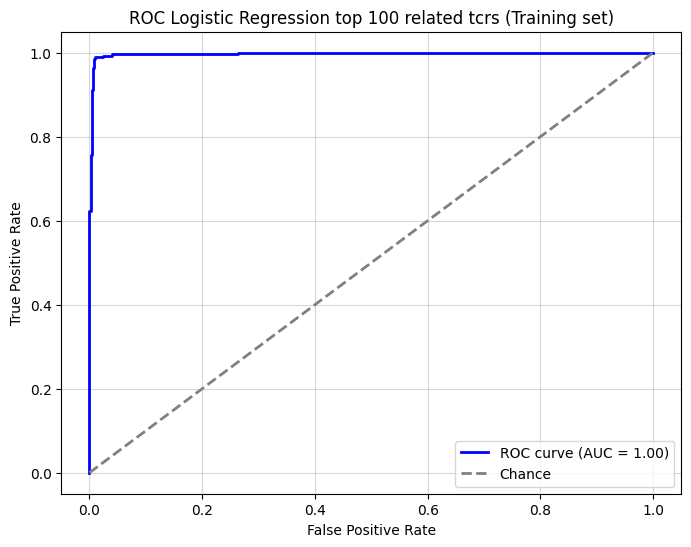

Sensitivity: 0.99
Specificity: 0.99
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       475
     Class 1       0.98      0.99      0.99       284

    accuracy                           0.99       759
   macro avg       0.99      0.99      0.99       759
weighted avg       0.99      0.99      0.99       759

ROC Logistic Regression top 100 related tcrs (Validation set)


C:\Users\fried\AppData\Local\Temp\ipykernel_15252\1054395001.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
C:\Users\fried\AppData\Local\Temp\ipykernel_15252\1054395001.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


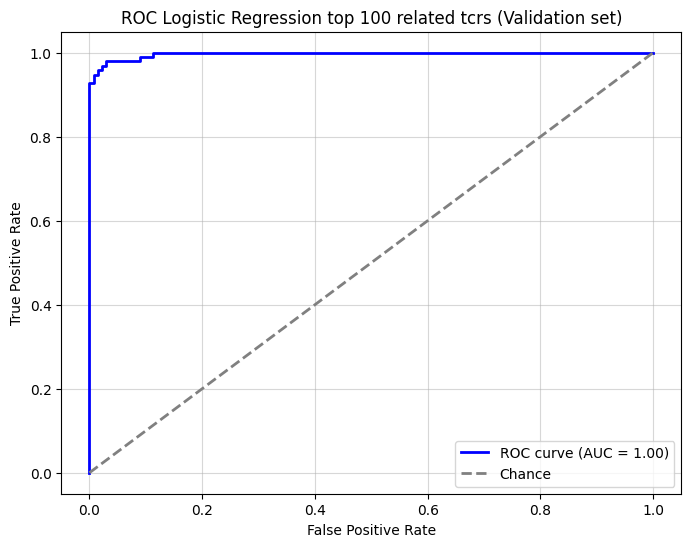

Sensitivity: 0.96
Specificity: 0.98
Accuracy: 0.97
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       133
     Class 1       0.98      0.96      0.97        96

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



,top_n,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,False,0.997024,0.958333,0.984962,0.973799


In [127]:
metrics_validation_data = []
metrics_training_data = []

bn = False
n = 100

patient_df_emerson = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_emerson = select_patients_hla_labelling(patient_df_emerson)

fisher_exact_results_df_emerson = read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df_emerson['TCR'] = fisher_exact_results_df_emerson['TCR'].apply(ast.literal_eval)

result_df_emerson = match_and_select_related_tcrs(fisher_exact_results_df_emerson, patient_df_emerson, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)



#training set
# 0 = False, 1 = True
result_df_emerson['has_HLA_A02_01'] = result_df_emerson['has_HLA_A02_01'].replace('None', np.nan)
#drop none values
result_df_emerson = result_df_emerson.dropna()
result_df_emerson['has_HLA_A02_01_label'] = result_df_emerson['has_HLA_A02_01'].astype('category').cat.codes

#select first 400 patients for training
result_df_emerson.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
result_df_training = result_df_emerson.iloc[:400]
result_df_training = pd.concat([train_result_df, result_df_training], ignore_index=True)

result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn, filename='results\\models\\logistic_regression_semi_supervised_training.joblib')


# Make roc curve
roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn)
sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

metrics_training_data.append({
    'top_n': n, 
    'benjamini_hochberg': bn,
    'roc_auc': roc_auc, 
    'sensitivity': sensitivity, 
    'specificity': specificity, 
    'accuracy': accuracy
}) 
#result_df_training_plot = result_df_copy.iloc[:400]
#plot_total_vs_significant_tcrs(result_df_training_plot, n)

#validation set
result_df_validation = result_df_emerson.iloc[400:]
X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
y_val = result_df_validation['has_HLA_A02_01_label']
result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
result_df_validation['prediction'] = model.predict(X_val)
roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn)
sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

metrics_validation_data.append({
    'top_n': n, 
    'benjamini_hochberg': bn,
    'roc_auc': roc_auc, 
    'sensitivity': sensitivity, 
    'specificity': specificity, 
    'accuracy': accuracy
})
#result_df_validation_plot = result_df_copy.iloc[400:]
#plot_total_vs_significant_tcrs(result_df_validation_plot, n, False)


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_semi_supervised.tsv')
write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_semi_supervised.tsv')

metrics_training_df
metrics_validation_df

In [128]:
print(len(result_df_validation))

229


### 7. Make the training data imbalanced
##### Lower the positive labels for HLA-A (from training data) to find a minimum threshold until where our trained model stays reliable


In [31]:
def select_positive_patients(patient_df, threshold=None):
    """
    Reduceert het aantal positieve labels ('has_HLA_A02_01' == True) tot een bepaalde threshold.
    
    Parameters:
        patient_df (pd.DataFrame): DataFrame met patiënten, inclusief de kolom 'has_HLA_A02_01'.
        threshold (float): Proportie van positieve labels om te behouden (tussen 0 en 1).
        
    Returns:
        pd.DataFrame: Gereduceerde DataFrame met de gewenste proportie positieve labels.
    """

    if threshold is None: # Als er geen threshold is, geef de originele DataFrame terug
        return patient_df
    
    
    # Splits positieve en negatieve patiënten
    patient_df_positive = patient_df[patient_df['has_HLA_A02_01'] == True]
    patient_df_negative = patient_df[patient_df['has_HLA_A02_01'] == False]
    
    
    # Willekeurig een subset van de positieve patiënten selecteren op basis van de threshold, 
    # waarbij threshold het aantal patiënten is dat behouden moet worden (tussen 0 en totaal aantal positieve patiënten)
    reduced_positive_df = patient_df_positive.sample(n=min(threshold, len(patient_df_positive)), random_state=42)

    #reduced_positive_df = patient_df_positive.sample(frac=threshold, random_state=42)
    
    # Combineer de negatieve patiënten met de gereduceerde positieve patiënten
    result_df = pd.concat([reduced_positive_df, patient_df_negative], ignore_index=True)
    
    return result_df


In [19]:
tcr_df = read_file('results\\tcr_df_output.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)

In [32]:
thresholds = [5, 10, 15, 30, 50, 100, None]

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = select_patients_hla_labelling(patient_df, 400)

for threshold in thresholds:
    patients_df_filtered = select_positive_patients(patient_df, threshold)
    print("threshold = " + str(threshold))
    print(patients_df_filtered['has_HLA_A02_01'].value_counts())
    fisher_exact_results_df = execute_fisher_exact(tcr_df, patients_df_filtered)
    if threshold == None:
        threshold = 'all'
    
    write_to_file(fisher_exact_results_df, 'results\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')

SyntaxError: invalid syntax (160660841.py, line 11)

Fisher exact:  1007245
Related TCRs fisher exact:  13922
Related TCRs Benjamini:  3
Training set:  400
has_HLA_A02_01
False    211
True       8
Name: count, dtype: int64
Training set:  219
ROC Logistic Regression top 3 related tcrs (Training set, Benjamini-Hochberg, Threshold = 0.05)


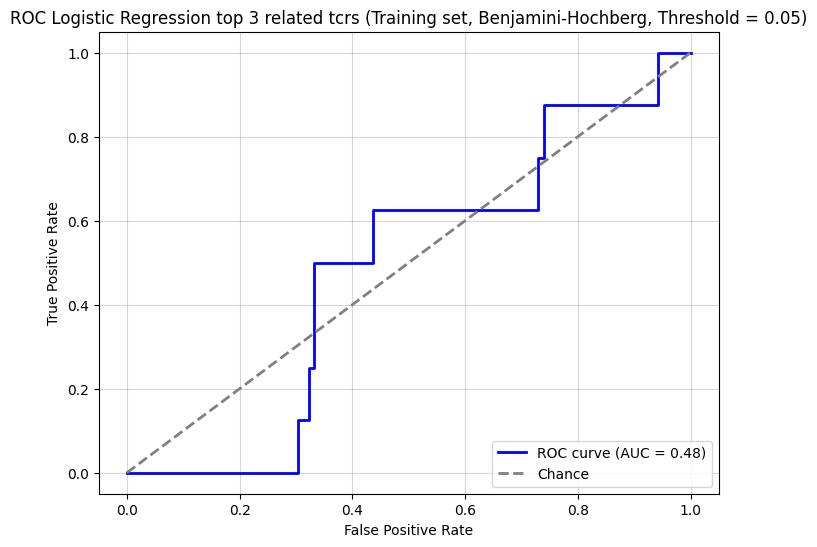

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.96
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98       211
     Class 1       0.00      0.00      0.00         8

    accuracy                           0.96       219
   macro avg       0.48      0.50      0.49       219
weighted avg       0.93      0.96      0.95       219

Related TCRs fisher exact:  13922


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Related TCRs Benjamini:  3
Validation set:  257
ROC Logistic Regression top 3 related tcrs (Validation set, Benjamini-Hochberg, Threshold = 0.05)


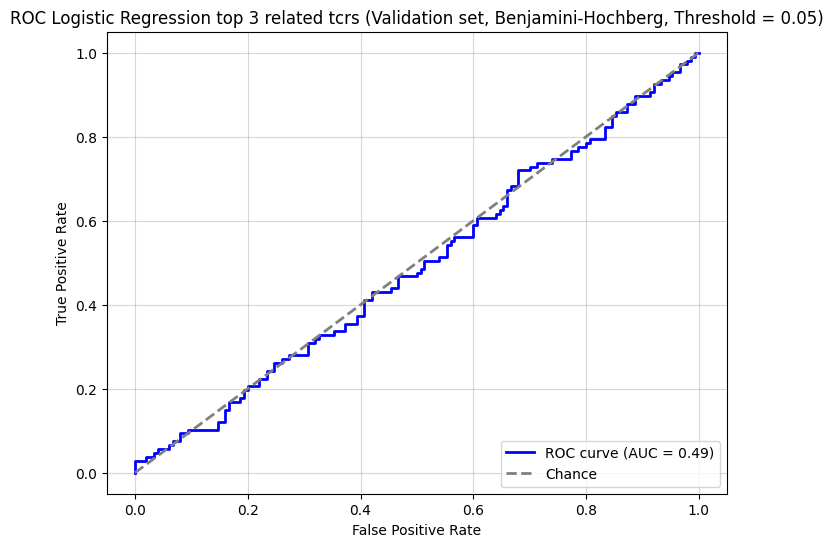

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.58
              precision    recall  f1-score   support

     Class 0       0.58      1.00      0.74       150
     Class 1       0.00      0.00      0.00       107

    accuracy                           0.58       257
   macro avg       0.29      0.50      0.37       257
weighted avg       0.34      0.58      0.43       257



c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fisher exact:  1007245
Related TCRs fisher exact:  23596
Related TCRs Benjamini:  11
Training set:  400
has_HLA_A02_01
False    211
True      16
Name: count, dtype: int64
Training set:  227
ROC Logistic Regression top 11 related tcrs (Training set, Benjamini-Hochberg, Threshold = 0.1)


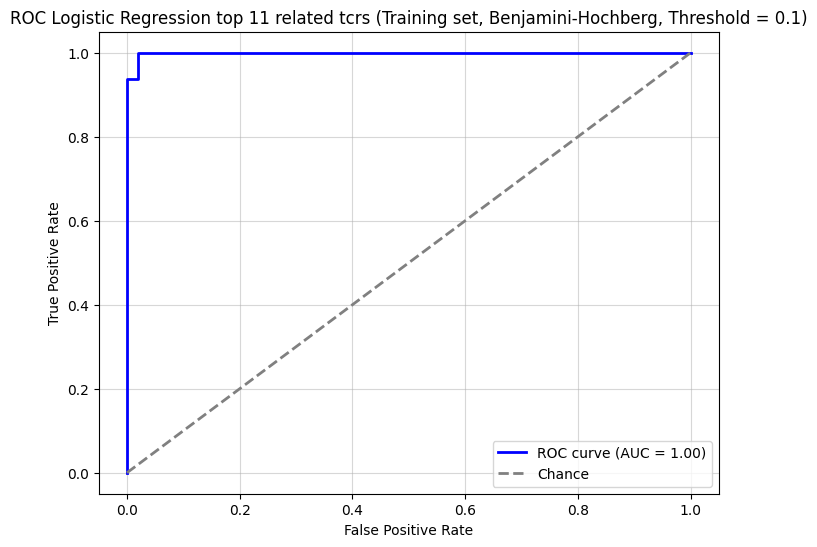

Sensitivity: 0.94
Specificity: 1.00
Accuracy: 1.00
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       211
     Class 1       1.00      0.94      0.97        16

    accuracy                           1.00       227
   macro avg       1.00      0.97      0.98       227
weighted avg       1.00      1.00      1.00       227

Related TCRs fisher exact:  23596
Related TCRs Benjamini:  11
Validation set:  257
ROC Logistic Regression top 11 related tcrs (Validation set, Benjamini-Hochberg, Threshold = 0.1)


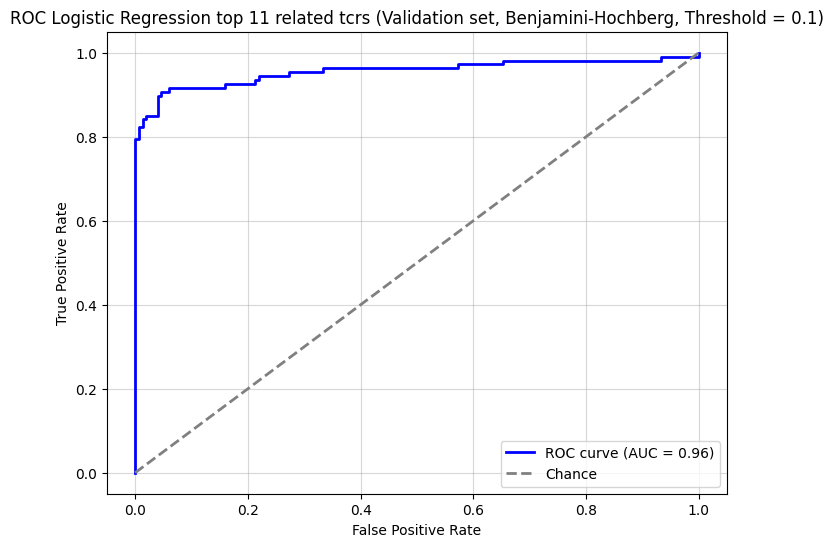

Sensitivity: 0.82
Specificity: 0.99
Accuracy: 0.92
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       150
     Class 1       0.99      0.82      0.90       107

    accuracy                           0.92       257
   macro avg       0.94      0.91      0.92       257
weighted avg       0.93      0.92      0.92       257

Fisher exact:  1007245
Related TCRs fisher exact:  28749
Related TCRs Benjamini:  41
Training set:  400
has_HLA_A02_01
False    211
True      48
Name: count, dtype: int64
Training set:  259
ROC Logistic Regression top 41 related tcrs (Training set, Benjamini-Hochberg, Threshold = 0.3)


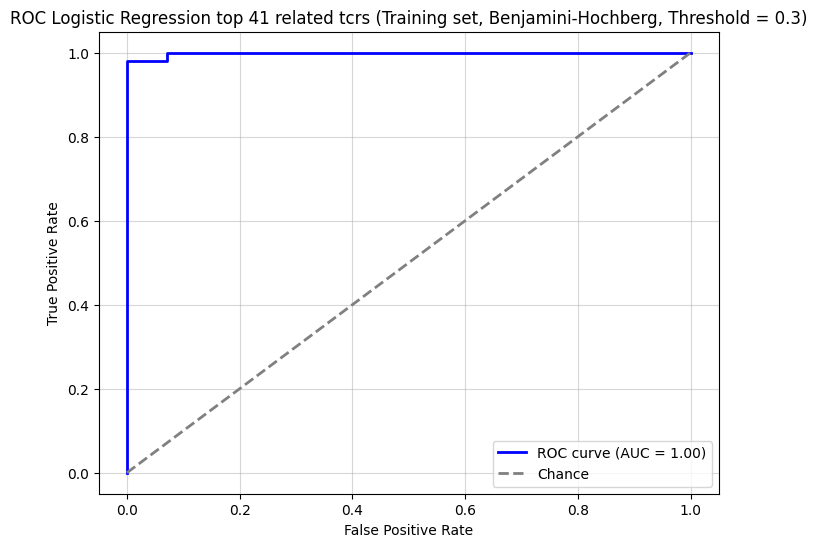

Sensitivity: 0.98
Specificity: 1.00
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       211
     Class 1       0.98      0.98      0.98        48

    accuracy                           0.99       259
   macro avg       0.99      0.99      0.99       259
weighted avg       0.99      0.99      0.99       259

Related TCRs fisher exact:  28749
Related TCRs Benjamini:  41
Validation set:  257
ROC Logistic Regression top 41 related tcrs (Validation set, Benjamini-Hochberg, Threshold = 0.3)


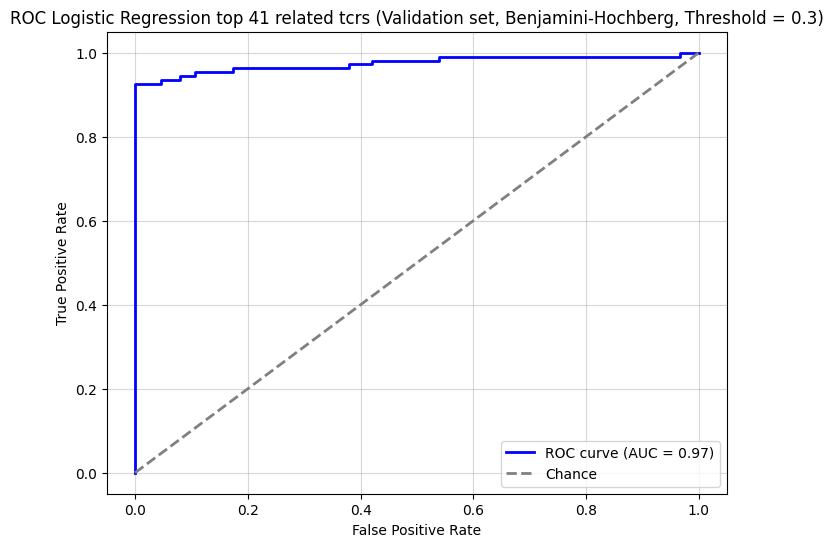

Sensitivity: 0.89
Specificity: 1.00
Accuracy: 0.95
              precision    recall  f1-score   support

     Class 0       0.93      1.00      0.96       150
     Class 1       1.00      0.89      0.94       107

    accuracy                           0.95       257
   macro avg       0.96      0.94      0.95       257
weighted avg       0.96      0.95      0.95       257

Fisher exact:  1007245
Related TCRs fisher exact:  18263
Related TCRs Benjamini:  57
Training set:  400
has_HLA_A02_01
False    211
True      80
Name: count, dtype: int64
Training set:  291
ROC Logistic Regression top 57 related tcrs (Training set, Benjamini-Hochberg, Threshold = 0.5)


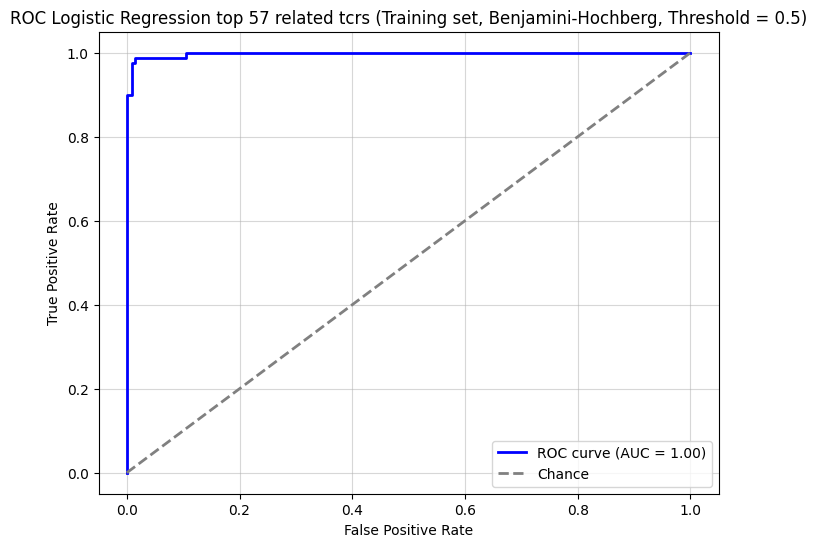

Sensitivity: 0.99
Specificity: 0.98
Accuracy: 0.98
              precision    recall  f1-score   support

     Class 0       1.00      0.98      0.99       211
     Class 1       0.95      0.99      0.97        80

    accuracy                           0.98       291
   macro avg       0.97      0.98      0.98       291
weighted avg       0.98      0.98      0.98       291

Related TCRs fisher exact:  18263
Related TCRs Benjamini:  57
Validation set:  257
ROC Logistic Regression top 57 related tcrs (Validation set, Benjamini-Hochberg, Threshold = 0.5)


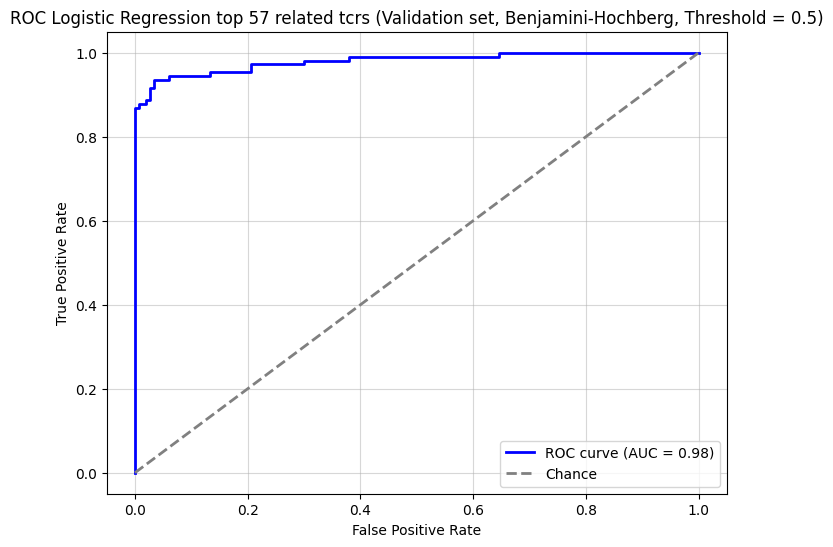

Sensitivity: 0.87
Specificity: 1.00
Accuracy: 0.95
              precision    recall  f1-score   support

     Class 0       0.91      1.00      0.96       150
     Class 1       1.00      0.87      0.93       107

    accuracy                           0.95       257
   macro avg       0.96      0.93      0.94       257
weighted avg       0.95      0.95      0.94       257

Fisher exact:  1007245
Related TCRs fisher exact:  18719
Related TCRs Benjamini:  72
Training set:  400
has_HLA_A02_01
False    211
True     113
Name: count, dtype: int64
Training set:  324
ROC Logistic Regression top 72 related tcrs (Training set, Benjamini-Hochberg, Threshold = 0.7)


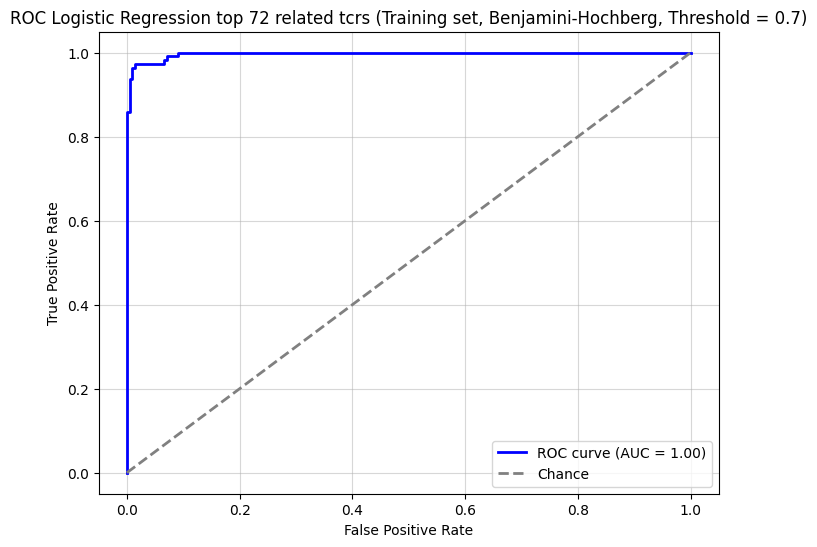

Sensitivity: 0.97
Specificity: 0.98
Accuracy: 0.98
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98       211
     Class 1       0.96      0.97      0.97       113

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324

Related TCRs fisher exact:  18719
Related TCRs Benjamini:  72
Validation set:  257
ROC Logistic Regression top 72 related tcrs (Validation set, Benjamini-Hochberg, Threshold = 0.7)


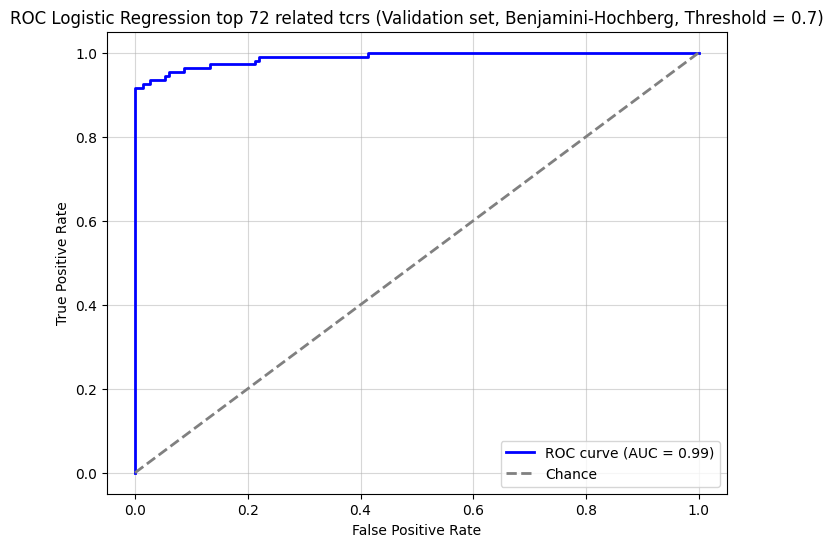

Sensitivity: 0.92
Specificity: 0.99
Accuracy: 0.96
              precision    recall  f1-score   support

     Class 0       0.94      0.99      0.97       150
     Class 1       0.99      0.92      0.95       107

    accuracy                           0.96       257
   macro avg       0.97      0.95      0.96       257
weighted avg       0.96      0.96      0.96       257



,top_n,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,3,0.05,True,0.491713,0.000000,1.000000,0.583658
1,11,0.10,True,0.955763,0.822430,0.993333,0.922179
2,41,0.30,True,0.974642,0.887850,1.000000,0.953307
3,57,0.50,True,0.980312,0.869159,1.000000,0.945525
4,72,0.70,True,0.988598,0.915888,0.993333,0.961089


In [75]:
thresholds = [0.05, 0.1, 0.3, 0.5, 0.7]

metrics_training_data = []
metrics_validation_data = []

patient_df = match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
#patient_df= select_patients_hla_labelling(patient_df)

bn = True
n =  100

for threshold in thresholds:
    n =  100
    fisher_exact_results_df = read_file('results\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')
    fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
    print("Fisher exact: ", len(fisher_exact_results_df))

    patient_df_training = select_patients_hla_labelling(patient_df, 400)
    patients_df_filtered = select_positive_patients(patient_df_training, threshold)

    #training set
    result_df_training, n = match_and_select_related_tcrs(fisher_exact_results_df, patients_df_filtered, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
    result_df_copy = result_df_training.copy()

    result_df_training = result_df_training.iloc[:400]
    print("Training set: ", len(result_df_training))
    print(result_df_training['has_HLA_A02_01'].value_counts())

    # Make a label for the target (has_HLA_A02_01), model can't handle boolean values
    # 0 = False, 1 = True
    result_df_training['has_HLA_A02_01'] = result_df_training['has_HLA_A02_01'].replace('None', np.nan)
    #drop none values
    result_df_training = result_df_training.dropna()
    result_df_training['has_HLA_A02_01_label'] = result_df_training['has_HLA_A02_01'].astype('category').cat.codes
    
    result_df_training.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)    
    print("Training set: ", len(result_df_training))
    

    filename = 'results\\models\\logistic_regression_top' + str(n) + '_related_tcrs_threshold_' + str(threshold) + '.joblib'
    result_df_training, model = make_classifier(result_df_training, n, benjamini_hochberg=bn, filename=filename)

    # Make roc curve
    roc_auc = plot_roc_curve(result_df_training, n, benjamini_hochberg=bn, threshold=threshold)
    sensitivity, specificity, accuracy = calculate_metrics(result_df_training)

    metrics_training_data.append({
        'top_n': n, 
        'benjamini_hochberg': bn,
        'roc_auc': roc_auc, 
        'sensitivity': sensitivity, 
        'specificity': specificity, 
        'accuracy': accuracy
    }) 
    
    #plot_total_vs_significant_tcrs(result_df_training, top_n=n, threshold=threshold)

    #validation set
    n =  100
    patient_df_validation = select_patients_hla_labelling(patient_df, 400, training=False)
    result_df_validation, n = match_and_select_related_tcrs(fisher_exact_results_df, patient_df_validation, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
    
    # 0 = False, 1 = True
    result_df_validation['has_HLA_A02_01'] = result_df_validation['has_HLA_A02_01'].replace('None', np.nan)
    result_df_validation = result_df_validation.dropna()
    result_df_validation['has_HLA_A02_01_label'] = result_df_validation['has_HLA_A02_01'].astype('category').cat.codes
    result_df_validation.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
    print("Validation set: ", len(result_df_validation))

    
    X_val = result_df_validation[['total_tcrs', 'related_tcrs']]
    y_val = result_df_validation['has_HLA_A02_01_label']
    result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
    result_df_validation['prediction'] = model.predict(X_val)
    roc_auc = plot_roc_curve(result_df_validation, n, False, benjamini_hochberg=bn, threshold=threshold)
    sensitivity, specificity, accuracy = calculate_metrics(result_df_validation)

    metrics_validation_data.append({
        'top_n': n, 
        'threshold': threshold,
        'benjamini_hochberg': bn,
        'roc_auc': roc_auc, 
        'sensitivity': sensitivity, 
        'specificity': specificity, 
        'accuracy': accuracy
    })
    #plot_total_vs_significant_tcrs(result_df_validation, top_n=n, training=False, threshold=threshold)
    
        

metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_thresholds.tsv')
write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_thresholds.tsv')

metrics_training_df
metrics_validation_df

In [76]:
metrics_training_df

,top_n,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,3,True,0.482820,0.000000,1.000000,0.963470
1,11,True,0.998815,0.937500,1.000000,0.995595
2,41,True,0.998519,0.979167,0.995261,0.992278
3,57,True,0.997808,0.987500,0.981043,0.982818
4,72,True,0.997232,0.973451,0.981043,0.978395
